/var/folders/y5/_38246qd6zd0lmzngc4zlt8h0000gn/T/ipykernel_60910/2235521653.py:94: RuntimeWarning: divide by zero encountered in divide
  accept_prob = prior_proposal / prior_current \
/var/folders/y5/_38246qd6zd0lmzngc4zlt8h0000gn/T/ipykernel_60910/2235521653.py:94: RuntimeWarning: divide by zero encountered in double_scalars
  accept_prob = prior_proposal / prior_current \
/var/folders/y5/_38246qd6zd0lmzngc4zlt8h0000gn/T/ipykernel_60910/2235521653.py:94: RuntimeWarning: invalid value encountered in multiply
  accept_prob = prior_proposal / prior_current \
/var/folders/y5/_38246qd6zd0lmzngc4zlt8h0000gn/T/ipykernel_60910/2235521653.py:94: RuntimeWarning: invalid value encountered in divide
  accept_prob = prior_proposal / prior_current \
/var/folders/y5/_38246qd6zd0lmzngc4zlt8h0000gn/T/ipykernel_60910/2235521653.py:94: RuntimeWarning: overflow encountered in divide
  accept_prob = prior_proposal / prior_current \


接受率为0.52
弹性模量的后验分布均值为58762.01
横截面积的后验分布均值为2.96
长度的后验分布均值为10.09


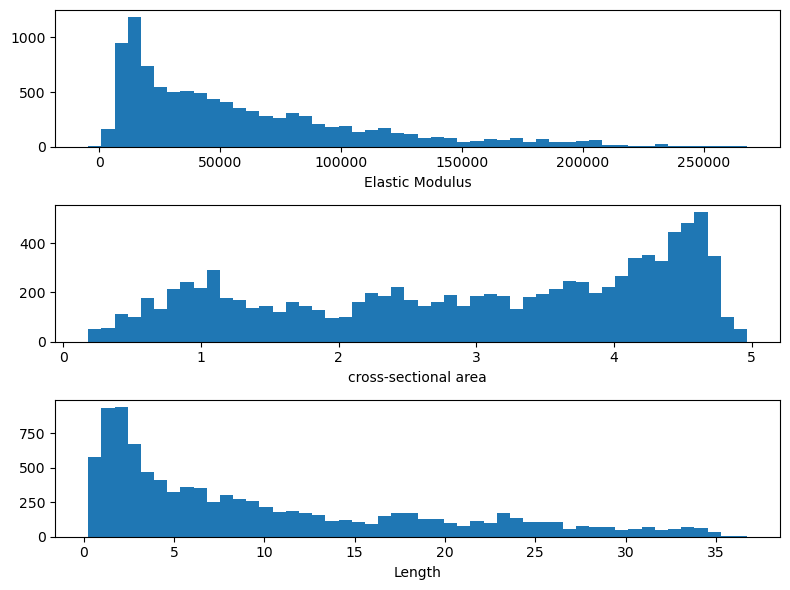

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 定义线性弹性模型函数
def linear_elastic_model(params, strain):
    """线性弹性模型函数

    参数:
    params: 模型参数（E：弹性模量，A：横截面积，L：长度）
    strain: 应变

    返回:
    stress: 应力
    """
    E, A, L = params
    stress = E * strain * (L / A)
    return stress

# 定义先验分布函数
def prior(params):
    """先验分布函数

    参数:
    params: 模型参数（E：弹性模量，A：横截面积，L：长度）

    返回:
    先验概率
    """
    E, A, L = params
    # 弹性模量和横截面积的先验分布为正态分布
    E_prior = np.random.normal(loc=100000, scale=10000)
    A_prior = np.random.normal(loc=1, scale=0.1)
    # 长度的先验分布为均匀分布
    L_prior = np.random.uniform(low=0.1, high=10)
    prior = (1 / (np.sqrt(2*np.pi)*10000)) * np.exp(-(E-E_prior)**2/(2*10000**2)) \
            * (1 / (np.sqrt(2*np.pi)*0.1)) * np.exp(-(A-A_prior)**2/(2*0.1**2)) \
            * (1 / (10 - 0.1))
    return prior

# 定义似然函数
def likelihood(params, strain, stress, sigma):
    """似然函数

    参数:
    params: 模型参数（E：弹性模量，A：横截面积，L：长度）
    strain: 应变
    stress: 应力
    sigma: 测量误差标准差

    返回:
    似然概率
    """
    model_stress = linear_elastic_model(params, strain)
    likelihood = (1 / (np.sqrt(2*np.pi)*sigma)) * np.exp(-(stress-model_stress)**2/(2*sigma**2))
    return likelihood

# 生成模拟数据
params_true = [100000, 1, 1]  # 真实参数
strain = np.random.uniform(low=-0.01, high=0.01, size=100)  # 100个随机应变值
stress = linear_elastic_model(params_true, strain)  # 对应的应力值
sigma = 10  # 测量误差标准差

        
# MCMC参数识别
n_iter = 10000  # 迭代次数
params_init = [50000, 1, 1]  # 初始参数值
params_chain = np.zeros((n_iter, 3))  # 参数链
params_chain[0] = params_init  # 将初始值放入参数链的第一行
accept_count = 0  # 记录接受次数

for i in range(1, n_iter):
    # 生成新的候选参数值
    params_current = params_chain[i-1]  # 当前参数值
    params_proposal = np.random.normal(loc=params_current, scale=[10000, 0.1, 1])  # 提议分布

    # 计算当前参数值的先验概率
    prior_current = prior(params_current)

    # 计算候选参数值的先验概率
    prior_proposal = prior(params_proposal)

    # 如果候选参数值的先验概率为0，则无法计算后验概率
    if prior_proposal == 0:
        params_chain[i] = params_current
        continue

    # 计算当前参数值的似然概率
    likelihood_current = likelihood(params_current, strain, stress, sigma)

    # 计算候选参数值的似然概率
    likelihood_proposal = likelihood(params_proposal, strain, stress, sigma)

    # 计算接受率
    accept_prob = prior_proposal / prior_current \
                  * likelihood_proposal / likelihood_current

    # 决定是否接受候选参数值
    if np.random.uniform() < accept_prob.all():
        params_chain[i] = params_proposal
        accept_count += 1  # 记录接受次数
    else:
        params_chain[i] = params_current


# 输出结果
print(f"接受率为{accept_count/n_iter:.2f}")
print(f"弹性模量的后验分布均值为{np.mean(params_chain[:,0]):.2f}")
print(f"横截面积的后验分布均值为{np.mean(params_chain[:,1]):.2f}")
print(f"长度的后验分布均值为{np.mean(params_chain[:,2]):.2f}")

# 绘制参数分布图
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
axs[0].hist(params_chain[:,0], bins=50)
axs[0].set_xlabel("Elastic Modulus")
axs[1].hist(params_chain[:,1], bins=50)
axs[1].set_xlabel("cross-sectional area")
axs[2].hist(params_chain[:,2], bins=50)
axs[2].set_xlabel("Length")
plt.tight_layout()
plt.show()
